# Feature Engineering

In this notebook we test various statistical transformations of our data in an attempt to create new informative features.

In [1]:
# Global variables for testing changes to this notebook quickly
NUM_FOLDS = 5
MODEL_SEED = 0
NUM_TREES = 25000
EARLY_STOP = 250
SUBMIT = False

In [2]:
# Essentials
import numpy as np
import pandas as pd
import scipy.stats as stats
import pyarrow
import pickle
import time
import matplotlib

# Models and Evaluation
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, plot_importance

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# List input files
import os
for dirname, _, filenames in os.walk('..\data'):
    for filename in filenames:
        if filename.endswith('.feather'):
            print(os.path.join(dirname, filename))

..\data\test.feather
..\data\train.feather


In [3]:
%%time

train = pd.read_feather(f'../data/train.feather')
test = pd.read_feather(f'../data/test.feather')

features = [x for x in train.columns if x not in ['id','claim','kfold','3fold','4fold','5fold','6fold']]

print("Train Size (Mb):", 
      round(train.memory_usage().sum() / 1024 ** 2, 2))

print("Test Size (Mb):", 
      round(test.memory_usage().sum() / 1024 ** 2, 2))

train.head()

Train Size (Mb): 512.5
Test Size (Mb): 248.48
Wall time: 1.13 s


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f114,f115,f116,f117,f118,claim,3fold,4fold,5fold,6fold
0,0,0.10859,0.004314,-37.566002,0.017364,0.28915,-10.25100,135.119995,168900.0,3.992400e+14,...,4378.799805,1.2096,8.613400e+14,140.100006,1.01770,1,2,3,4,5
1,1,0.10090,0.299610,11822.000000,0.276500,0.45970,-0.83733,1721.900024,119810.0,3.874100e+15,...,913.229980,1.2464,7.575100e+15,1861.000000,0.28359,0,1,1,2,2
2,2,0.17803,-0.006980,907.270020,0.272140,0.45948,0.17327,2298.000000,360650.0,1.224500e+13,...,45119.000000,1.1764,3.218100e+14,3838.199951,0.40690,1,1,1,2,2
3,3,0.15236,0.007259,780.099976,0.025179,0.51947,7.49140,112.510002,259490.0,7.781400e+13,...,4952.399902,1.1784,4.533000e+12,4889.100098,0.51486,1,0,0,0,0
4,4,0.11623,0.502900,-109.150002,0.297910,0.34490,-0.40932,2538.899902,65332.0,1.907200e+15,...,3856.500000,1.4830,-8.991300e+12,NaN,0.23049,1,1,1,1,2


# Baseline

In [4]:
# Scores, validation and test predictions
preds = np.zeros((test.shape[0],))
oof_preds = np.zeros((train.shape[0],))
scores = np.zeros(NUM_FOLDS)
  
for i in range(NUM_FOLDS):
    start = time.time()
    X_train = train[train[f'{NUM_FOLDS}fold'] != i][features].copy()
    X_valid = train[train[f'{NUM_FOLDS}fold'] == i][features].copy()
    y_train = train[train[f'{NUM_FOLDS}fold'] != i]['claim'].copy()
    y_valid = train[train[f'{NUM_FOLDS}fold'] == i]['claim'].copy()
    X_test = test[features].copy()


    model = LGBMClassifier(random_state=MODEL_SEED,
                           n_estimators = NUM_TREES)
    model =  model.fit(X_train, y_train,
                       verbose = False,
                       eval_set = [(X_valid, y_valid)],
                       eval_metric = "auc",
                       early_stopping_rounds = EARLY_STOP
                      )
    
    # Generate predictions on test set and validation set
    valid_preds = model.predict_proba(X_valid)[:,1]
    preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        
    # Store scores and out-of-fold predictions
    oof_preds[train[f'{NUM_FOLDS}fold'] == i] = valid_preds
    scores[i] = roc_auc_score(y_valid, valid_preds)
    
    end = time.time()
        
    print(f"LightGBM Fold {i} (AUC):", 
          round(scores[i], 6), " ",
          str(round(end-start, 3))+"s")
    
print("\nLightGBM (Avg):", round(scores.mean(), 6))
print("LightGBM (Min):", round(scores.min(), 6))
print(f'OOF AUC: ', roc_auc_score(train['claim'], oof_preds))

LightGBM Fold 0 (AUC): 0.804226   88.055s
LightGBM Fold 1 (AUC): 0.805669   87.267s
LightGBM Fold 2 (AUC): 0.805595   98.514s
LightGBM Fold 3 (AUC): 0.805048   92.756s
LightGBM Fold 4 (AUC): 0.802824   118.614s

LightGBM (Avg): 0.804673
LightGBM (Min): 0.802824
OOF AUC:  0.804627509973545


# Baseline Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

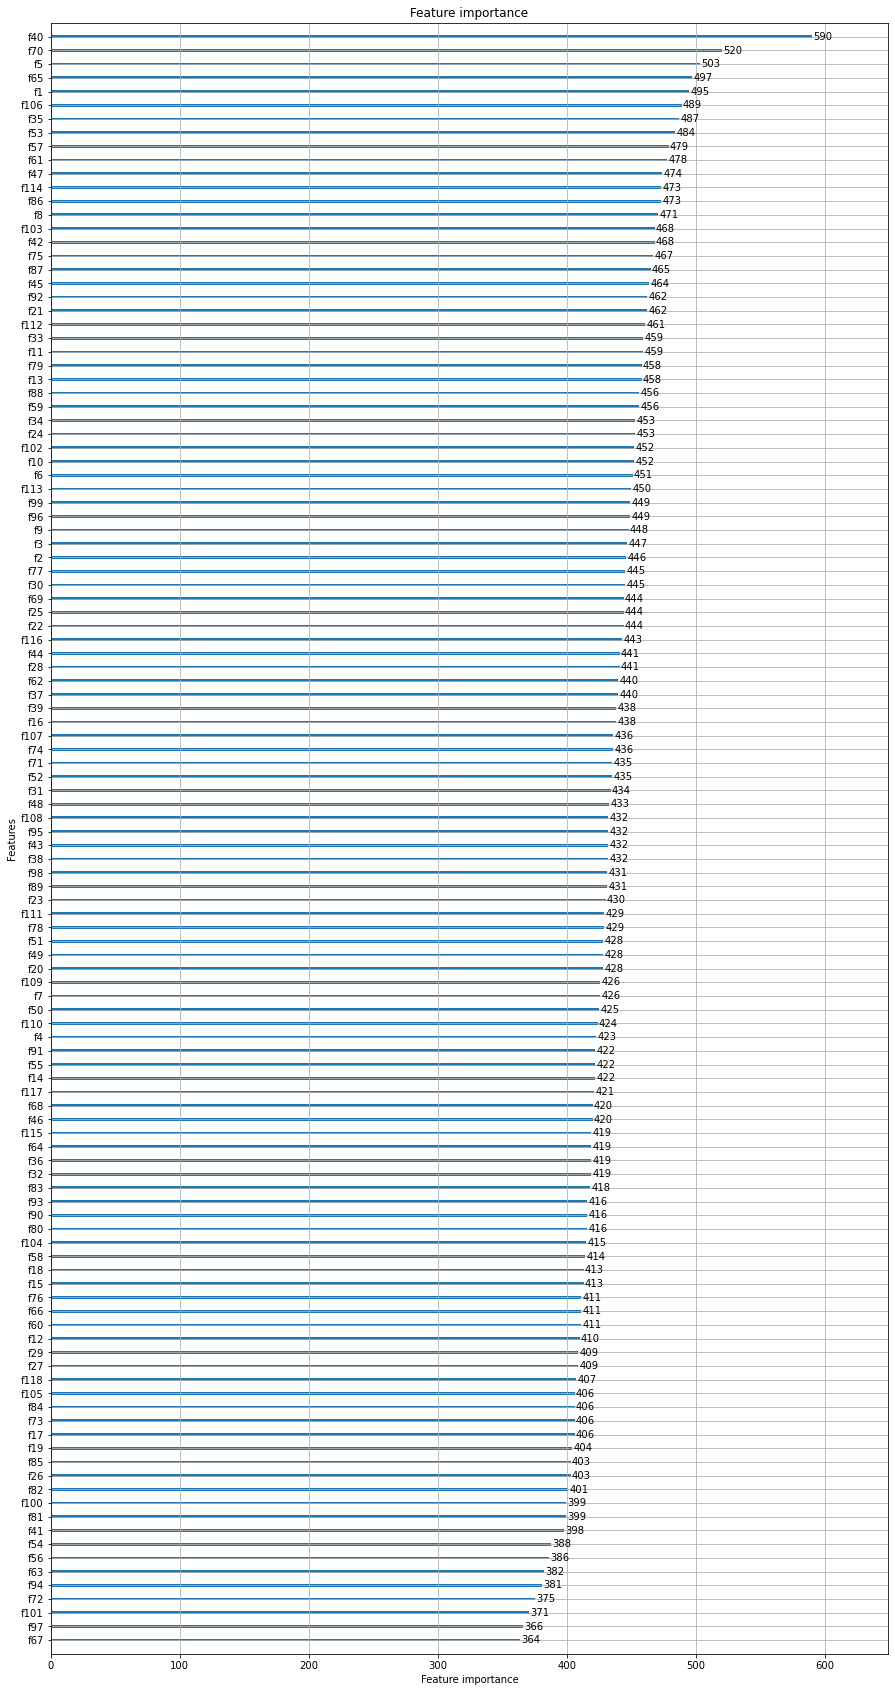

In [5]:
plot_importance(model, figsize=(15,30))

# Static Transformations

Here we test features which are calculated using only data found within a single row.

In [6]:
def create_row_stats(data):
    new_data = data.copy()
    new_data['nan_count'] = data.isnull().sum(axis=1)
    new_data['nan_std'] = data.isnull().std(axis=1)
    new_data['min'] = data.min(axis=1)
    new_data['std'] = data.std(axis=1)
    new_data['max'] = data.max(axis=1)
    new_data['median'] = data.median(axis=1)
    new_data['mean'] = data.mean(axis=1)
    new_data['var'] = data.var(axis=1)
    new_data['sum'] = data.sum(axis=1)
    new_data['sem'] = data.sem(axis=1)
    new_data['skew'] = data.skew(axis=1)
    new_data['median_abs_dev'] = stats.median_abs_deviation(data, axis=1)
    new_data['zscore'] = (np.abs(stats.zscore(data))).sum(axis=1)
    return new_data

In [7]:
train = create_row_stats(train)
test = create_row_stats(test)
features = [x for x in train.columns if x not in ['id','claim','kfold','3fold','4fold','5fold','6fold']]

# Training

In [8]:
# Scores, validation and test predictions
preds = np.zeros((test.shape[0],))
oof_preds = np.zeros((train.shape[0],))
scores = np.zeros(NUM_FOLDS)
  
for i in range(NUM_FOLDS):
    start = time.time()
    X_train = train[train[f'{NUM_FOLDS}fold'] != i][features].copy()
    X_valid = train[train[f'{NUM_FOLDS}fold'] == i][features].copy()
    y_train = train[train[f'{NUM_FOLDS}fold'] != i]['claim'].copy()
    y_valid = train[train[f'{NUM_FOLDS}fold'] == i]['claim'].copy()
    X_test = test[features].copy()


    model = LGBMClassifier(random_state=MODEL_SEED,
                           n_estimators = NUM_TREES)
    model =  model.fit(X_train, y_train,
                       verbose = False,
                       eval_set = [(X_valid, y_valid)],
                       eval_metric = "auc",
                       early_stopping_rounds = EARLY_STOP
                      )
    
    # Generate predictions on test set and validation set
    valid_preds = model.predict_proba(X_valid)[:,1]
    preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        
    # Store scores and out-of-fold predictions
    oof_preds[train[f'{NUM_FOLDS}fold'] == i] = valid_preds
    scores[i] = roc_auc_score(y_valid, valid_preds)
    
    end = time.time()
        
    print(f"LightGBM Fold {i} (AUC):", 
          round(scores[i], 6), " ",
          str(round(end-start, 3))+"s")
    
print("\nLightGBM (Avg):", round(scores.mean(), 6))
print("LightGBM (Min):", round(scores.min(), 6))
print(f'OOF AUC: ', roc_auc_score(train['claim'], oof_preds))

LightGBM Fold 0 (AUC): 0.813762   51.097s
LightGBM Fold 1 (AUC): 0.81497   57.748s
LightGBM Fold 2 (AUC): 0.814245   50.906s
LightGBM Fold 3 (AUC): 0.813413   50.936s
LightGBM Fold 4 (AUC): 0.810788   53.943s

LightGBM (Avg): 0.813435
LightGBM (Min): 0.810788
OOF AUC:  0.8134005202255259


# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

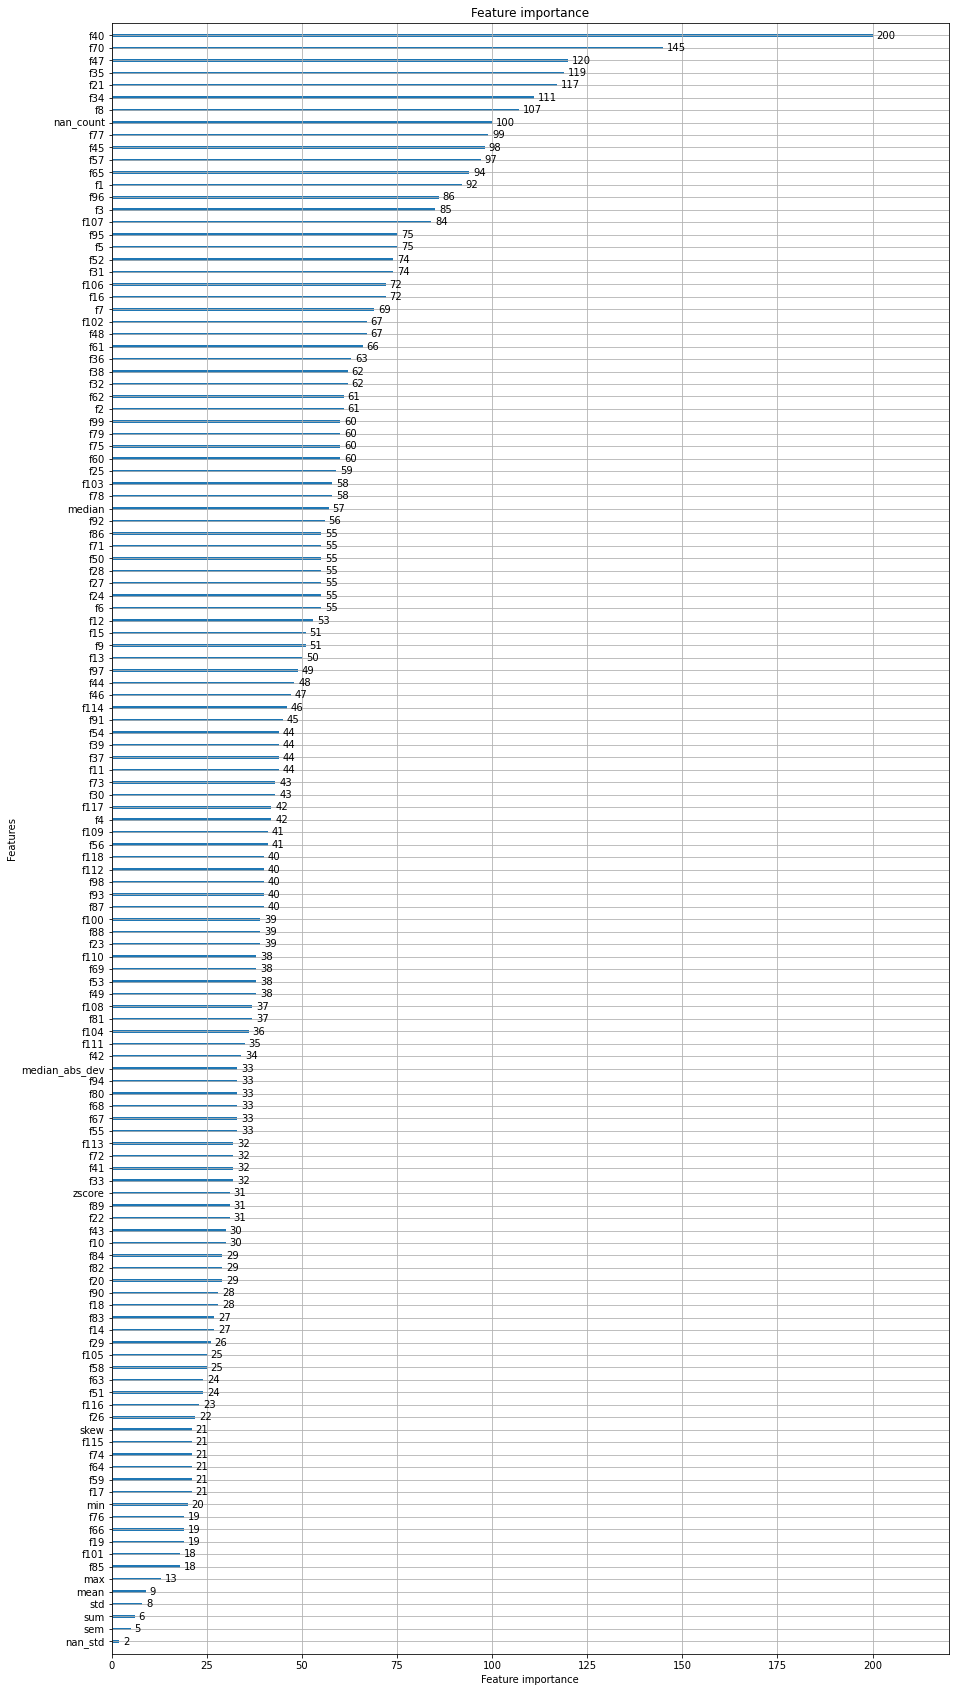

In [9]:
plot_importance(model, figsize=(15,30))

We notice that our new features not only result in better AUC scores but reduce the training time to roughly 2/3 of what it was previously. For the remaining notebooks we will use all of the transformations except those with less feature importance than any of the original features.

In [10]:
# New function
def create_row_stats(data):
    new_data = data.copy()
    new_data['nan_count'] = data.isnull().sum(axis=1)
    #new_data['nan_std'] = data.isnull().std(axis=1)
    new_data['min'] = data.min(axis=1)
    #new_data['std'] = data.std(axis=1)
    #new_data['max'] = data.max(axis=1)
    new_data['median'] = data.median(axis=1)
    #new_data['mean'] = data.mean(axis=1)
    new_data['var'] = data.var(axis=1)
    #new_data['sum'] = data.sum(axis=1)
    #new_data['sem'] = data.sem(axis=1)
    new_data['skew'] = data.skew(axis=1)
    new_data['median_abs_dev'] = stats.median_abs_deviation(data, axis=1)
    new_data['zscore'] = (np.abs(stats.zscore(data))).sum(axis=1)
    return new_data